In [1]:
import numpy as np
import matplotlib.pyplot as plt
#Rabi Frequency
Omg=5*1e4
#Raman pulse duration
tau=(1/(4*Omg)) 
T=2.5e-2 # time between raman pulses

In [2]:
import pandas as pd
import scipy as sp
import scipy.fftpack
import csv

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')


Text(0, 0.5, 'PSD')

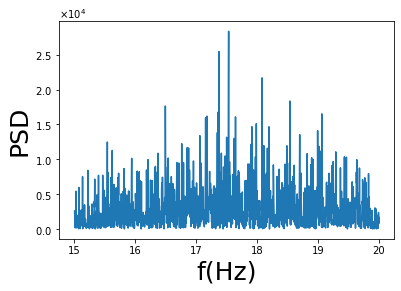

In [4]:
sensor_data = pd.read_csv('Bus_sensor_2Apr1030.csv')
accData=sensor_data.values.tolist()
accData=np.asarray([np.asarray(elem) for elem in accData])
sensor_data['acc_z_scaled'] = sensor_data['a_z'] / 4096.0
sensor_data['gyro_z_scaled'] = sensor_data['g_z'] / 131.0
test_data_for_fft = np.array(sensor_data['acc_z_scaled'][80000:155000])
#test_data_for_fft = test_data_for_fft*10e-6
fs = 272.628
test_fft =  sp.fftpack.fft(test_data_for_fft)
time_step  = 1.0/fs
test_psd = np.abs(test_fft)**2

freq = sp.fftpack.fftfreq(len(test_psd), time_step)

min_freq = 0.5
max_freq = fs/2.0
fftfreq_pos = (freq > min_freq) & (freq <= max_freq)
freqWin1=(freq > 15) & (freq <= 20)

figure,ax=plt.subplots(1)
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 


plt.rcParams['figure.figsize'] = [12,7]
ax.plot(freq[freqWin1], test_psd[freqWin1])
ax.tick_params(labelsize=10)
ax.set_xlabel(r'f(Hz)',fontsize=25)
ax.set_ylabel(r'PSD',fontsize=25)
#ax.set_ylim(1e-7)
#plt.savefig('accerelationTransferFunction.png')


## Transfer Function(eq.2.54)<br>
$H(\omega)=\frac{4\omega\Omega_{R}}{\omega^{2}-\Omega_{R}^{2}}\sin\left(\frac{\omega(T+2\tau)}{2}\right)\left[\cos\left(\frac{\omega(T+2\tau)}{2}\right)+\frac{\Omega}{\omega}\sin\left(\frac{\omega T}{2}\right)\right]$ <br>
<br>
__(Rosi, G. (2012). Precision gravity measurements with atom interferometry. PhD. University of Pisa.)__ <br>

$H_{a}(\omega)=\frac{k_{eff}^{2}}{\omega^{4}}|H(\omega)|^{2}$

In [5]:
freqArr=freq[fftfreq_pos]
#testArr=test_psd[fftfreq_pos]
keff=4*np.pi/(780*10**(-9))
H0=(4*freqArr*Omg/(freqArr**2-Omg**2))*np.sin(2*np.pi*(freqArr/2.)*(T+2*tau))*(np.cos(2*np.pi*freqArr*(T+2*tau)/2.)+(Omg/freqArr)*np.sin(2*np.pi*freqArr*T/2.))
H_1=H0*H0
H_a=keff**2*(2*np.pi*freqArr)**(-4)*H_1

In [6]:
Amp=H_a[0]
Amp

101416669.71731605

Text(0, 0.5, '$H_{a}(2\\pi f)^{2}/H_{a}(0)$')

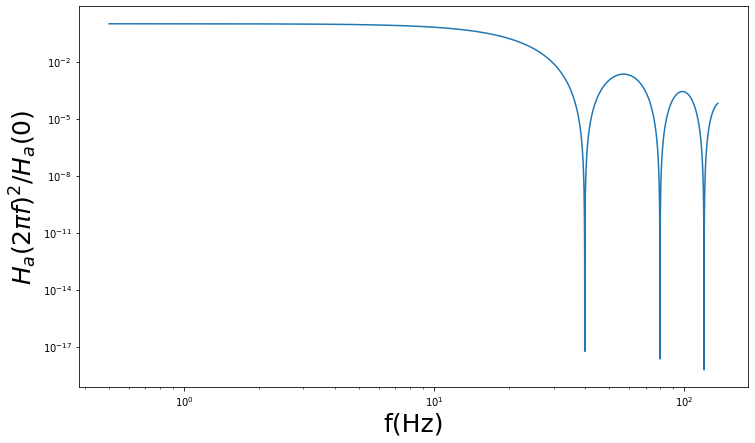

In [7]:

figure,ax=plt.subplots(1)
plt.rcParams['figure.figsize'] =  [12,7]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(freqArr,H_a/(H_a[0]))
ax.tick_params(labelsize=10)
ax.set_xlabel('f(Hz)',fontsize=25)
ax.set_ylabel(r'$H_{a}(2\pi f)^{2}/H_{a}(0)$',fontsize=25)

#ax.set_ylim(1e-7)
#plt.savefig('accerelationTransferFunction.png')


$\sigma^{2}_{g}(\tau_{m})=\frac{1}{2m^{2}T^{4}k_{eff}^{2}}\int_{0}^{\infty}d\omega H^{2}_{a}(\omega)\frac{4\sin(\omega\tau_{m})^{4}}{\sin(\omega T_{c})^{2}}S_{a}(\omega)$, $\tau_{m}=mT_{c}, m\geq 1$<br>
__(Rosi, G. (2012). Precision gravity measurements with atom interferometry. PhD. University of Pisa.)__<br>
__Measurement of local gravity using atom interferometry. Christian Freier Diploma thesis, Humboldt-Universität zu Berlin, 2010.__

## Tc=265 secs (275 secs is noise period from bus data)

In [8]:
#do not need this part
#transmissibility
len(freq[freqWin1])
transm=np.concatenate([np.concatenate([np.linspace(0.005,0.001,450),np.linspace(0.00101,0.01,450)]),np.linspace(0.01,0.005,476)])

In [9]:
df=freq[freqWin1][1]-freq[freqWin1][0]
print (df)

H0=(4*freq[freqWin1]*Omg/(freq[freqWin1]**2-Omg**2))*np.sin(2*np.pi*(freq[freqWin1]/2.)*(T+2*tau))*(np.cos(2*np.pi*freq[freqWin1]*(T+2*tau)/2.)+(Omg/freq[freqWin1])*np.sin(2*np.pi*freq[freqWin1]*T/2.))
H_1=H0*H0
H_a=keff**2*(2*np.pi*freq[freqWin1])**(-4)*H_1
Tc=1/df-10
tau_m=np.linspace(1,10000,10000)*Tc

h=lambda t:4*np.sin(2*np.pi*freq[freqWin1]*t)**4/np.sin(2*np.pi*freq[freqWin1]*Tc)**2
sigma_g=[((np.sum((H_a/H_a[0])*test_psd[freqWin1]*transm*df*h(t))/(2*(t/Tc)**2)))/(keff**2*T**4) for t in tau_m]
print("size(tau_m):",np.size(tau_m))
print("size(h):",np.size(h))
print("size(freq):",np.size(freq))

print("size(test_psd[freqWin1]):",np.size(test_psd[freqWin1]))
print("size(H_a):",np.size(H_a))
print("size(H_1):",np.size(H_1))
print("size(H0):",np.size(H0))
print(("H_a[0]:",H_a[0]))

print("size(sigma_g):",np.size(sigma_g))

0.0036350399999989236
size(tau_m): 10000
size(h): 1
size(freq): 75000
size(test_psd[freqWin1]): 1376
size(H_a): 1376
size(H_1): 1376
size(H0): 1376
('H_a[0]:', 38361649.50772624)
size(sigma_g): 10000


In [10]:
1/df

275.10013644974913

In [11]:
#freq[freqWin1]

In [12]:
#len(tau_m)

Text(0, 0.5, 'Allen deviation ($\\mu$ gal)')

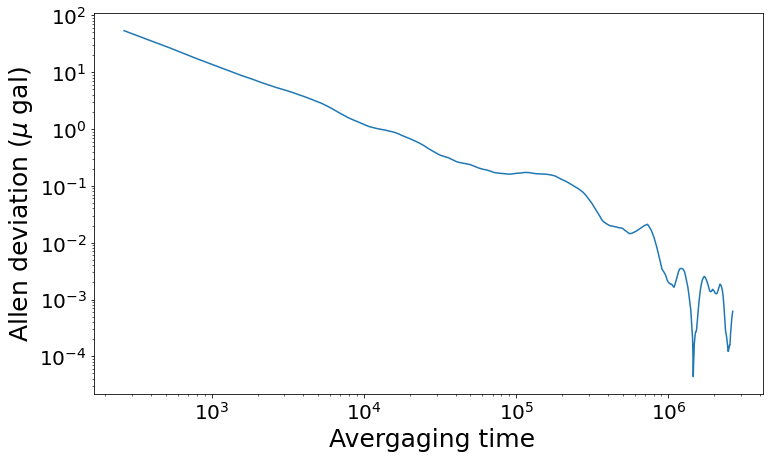

In [13]:
figure,ax=plt.subplots(1)
plt.rcParams['figure.figsize'] = [12,7]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(tau_m,np.asarray(sigma_g)*10**8)
#ax.plot(tau_m,sigma_g)
ax.tick_params(labelsize=20)
ax.set_xlabel(r' Avergaging time',fontsize=25)
ax.set_ylabel(r'Allen deviation ($\mu$ gal)',fontsize=25)
#ax.set_ylim(1e-7)

In [14]:
Tc=1/df-274.1#10
tau_m=np.linspace(1,500,500)*Tc
#tau_m=np.linspace(1,10000,10000)*Tc

h=lambda t:4*np.sin(2*np.pi*freq[freqWin1]*t)**4/np.sin(2*np.pi*freq[freqWin1]*Tc)**2
sigma_g=[((np.sum((H_a/H_a[0])*test_psd[freqWin1]*transm*df*h(t))/(2*(t/Tc)**2)))/(keff**2*T**4) for t in tau_m]
print("cycle time in secs",Tc)

cycle time in secs 1.0001364497491068


Text(0, 0.5, 'Allen deviation ($\\mu$ gal)')

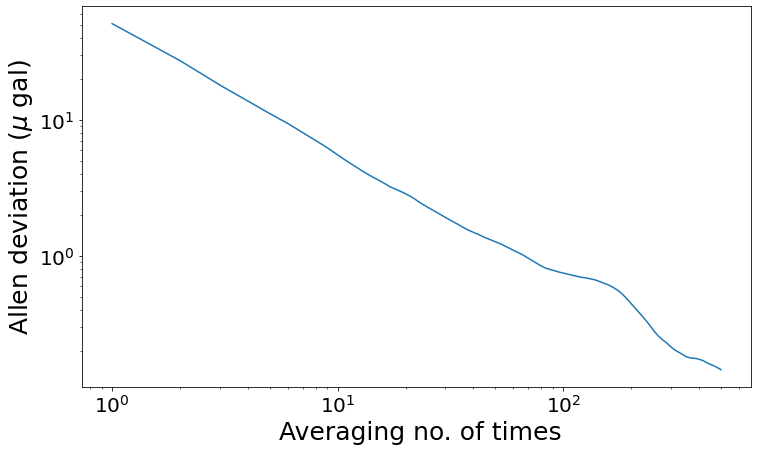

In [15]:
figure,ax=plt.subplots(1)
plt.rcParams['figure.figsize'] = [12,7]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(tau_m,np.asarray(sigma_g)*10**8)
#ax.plot(tau_m_1,sigma_g_1)
ax.tick_params(labelsize=20)
ax.set_xlabel(r' Averaging no. of times',fontsize=25)
ax.set_ylabel(r'Allen deviation ($\mu$ gal)',fontsize=25)
#ax.set_ylim(1e-7)

## Tc=275.2 secs (275 secs is noise period from bus data)

In [16]:
#df=freq[freqWin1][1]-freq[freqWin1][0]
#H0=(4*freq[freqWin1]*Omg/(freq[freqWin1]**2-Omg**2))*np.sin(2*np.pi*(freq[freqWin1]/2.)*(T+2*tau))*(np.cos(2*np.pi*freq[freqWin1]*(T+2*tau)/2.)+(Omg/freq[freqWin1])*np.sin(2*np.pi*freq[freqWin1]*T/2.))
#H_1=H0*H0
#H_a=keff**2*(2*np.pi*freq[freqWin1])**(-4)*H_1
#Tc=1/df+0.5
#tau_m_1=np.linspace(1,10000,10000)*Tc
#h=lambda t:4*np.sin(2*np.pi*freq[freqWin1]*t)**4/np.sin(2*np.pi*freq[freqWin1]*Tc)**2
#sigma_g_1=[((np.sum((H_a/H_a[0])*test_psd[freqWin1]*transm*df*h(t))/(2*(t/Tc)**2)))/(keff**2*T**4) for t in tau_m]

In [17]:
#figure,ax=plt.subplots(1)
#plt.rcParams['figure.figsize'] = [12,7]
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.plot(tau_m_1,np.asarray(sigma_g_1)*10**8)
#ax.plot(tau_m_1,sigma_g_1)
#ax.tick_params(labelsize=20)
#ax.set_xlabel(r'averaging time',fontsize=25)
#ax.set_ylabel(r'Allan deviation in $\mu$ gal',fontsize=25)
#ax.set_ylim(1e-7)

## Tc=275 secs (275 secs is noise period from bus data)

In [18]:
#Tc2=1/df
#h2=lambda t:4*np.sin(2*np.pi*freqArr*t)**4/np.sin(2*np.pi*freqArr*Tc2)**2
#tau_m_2=np.linspace(1,10000,10000)*Tc2
#sigma_g_2=[((np.sum((H_a/H_a[0])*testArr*df*h(t))/(2*(t/Tc2)**2))) for t in tau_m_2]

In [19]:
#figure,ax=plt.subplots(1)
#plt.rcParams['figure.figsize'] = [12,7]
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.plot(tau_m_2,sigma_g_2)
#ax.plot(tau_m_1,sigma_g_1)
#ax.tick_params(labelsize=20)
#ax.set_xlabel(r'$\tau_{m}$',fontsize=25)
#ax.set_ylabel(r'$\sigma^{2}_{g}(\tau_{m})$',fontsize=25)
#ax.set_ylim(1e-7)

The plots show variation in allan deviation of gravity field with averaging time in the bakcground of vibration noise
https://advances.sciencemag.org/content/5/9/eaax0800 Results are in good comparision with this reference See fig 2.
